# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on the training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {64, 128, 256, 512}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.


This might take a while to run, so plan your time carefully.

In [5]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.To reduce repeated code, place your

- network (MLP defined in QA1)

- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [132]:
from common_utils import MLP, CustomDataset, preprocess_dataset, EarlyStopper, preprocess


# Binary Cross Entropy Loss for binary classification
loss_fn = nn.BCELoss()

# Read the dataset
df = pd.read_csv('simplified.csv')

# Create the label from the filename since filename contains the label
df['label'] = df['filename'].str.split('_').str[-2]

# From the dataset given, we will drop filename and label since filename doesn't provide any detail and label is the prediction task
col_drop = ["filename", "label"]

# Preprocess the dataset (split and scale)
X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df, col_drop= col_drop)

In [133]:
X_train_scaled.shape

(9645, 77)

In [134]:
X_test_scaled.shape

(2412, 77)

In [135]:
df.shape

(12057, 79)

2.Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [136]:
def generate_cv_folds_for_batch_sizes(batch_sizes, X_train_scaled, y_train, num_folds=5):
    """
    Generates cross-validation folds for different batch sizes using already scaled data.

    Args:
        batch_sizes (list): List of batch sizes (e.g., [64, 128, 256, 512]).
        X_train_scaled (ndarray): Scaled input features for training data.
        y_train (ndarray): Labels for training data.
        num_folds (int): Number of cross-validation folds (default is 5).

    Returns:
        X_train_scaled_dict (dict): Dictionary where each key is a batch size and the value is a list of preprocessed training data for each fold.
        X_val_scaled_dict (dict): Dictionary where each key is a batch size and the value is a list of preprocessed validation data for each fold.
        y_train_dict (dict): Dictionary where each key is a batch size and the value is a list of labels for the training folds.
        y_val_dict (dict): Dictionary where each key is a batch size and the value is a list of labels for the validation folds.
    """

    # Initialize dictionaries to store the results
    X_train_scaled_dict = {batch_size: [] for batch_size in batch_sizes}
    X_val_scaled_dict = {batch_size: [] for batch_size in batch_sizes}
    y_train_dict = {batch_size: [] for batch_size in batch_sizes}
    y_val_dict = {batch_size: [] for batch_size in batch_sizes}

    """
    example of how X_train_scaled_dict will look like
    X_train_scaled_dict = {
        64: [],    # List for training data using batch size 64
        128: [],   # List for training data using batch size 128
        256: [],   # List for training data using batch size 256
        512: []    # List for training data using batch size 512
    }

    """

    # Perform K-Fold Cross Validation
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=1)

    """
    kf.split(X_train_scaled) uses the KFold object (kf) to split the scaled training data (X_train_scaled) into multiple folds (in this case, 5 folds). For each fold:
        train_idx: The indices of the training samples for that fold.
        val_idx: The indices of the validation samples for that fold.
    """

    # Splits the training data into training and validation sets for each fold, storing the preprocessed data and labels in dictionaries.
    
    # Iterate through each batch size 
    for batch_size in batch_sizes:

        # For each fold, we will store the preprocessed train and validation sets
        for train_idx, val_idx in kf.split(X_train_scaled):
            
            # Split the dataset into training and validation for the current fold
            X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            # Append the scaled data and corresponding labels to the dictionaries
            X_train_scaled_dict[batch_size].append(X_train_fold)
            X_val_scaled_dict[batch_size].append(X_val_fold)
            y_train_dict[batch_size].append(y_train_fold)
            y_val_dict[batch_size].append(y_val_fold)

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

batch_sizes = [64, 128, 256, 512]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train_scaled, y_train)

In [137]:
# Checking the results 
print("X_train_scaled_dict")
for batch_size, fold_vector in X_train_scaled_dict.items():
    print(batch_size)
    print("Input Feature shape", [fold.shape for fold in fold_vector])

X_train_scaled_dict
64
Input Feature shape [(7716, 77), (7716, 77), (7716, 77), (7716, 77), (7716, 77)]
128
Input Feature shape [(7716, 77), (7716, 77), (7716, 77), (7716, 77), (7716, 77)]
256
Input Feature shape [(7716, 77), (7716, 77), (7716, 77), (7716, 77), (7716, 77)]
512
Input Feature shape [(7716, 77), (7716, 77), (7716, 77), (7716, 77), (7716, 77)]


In [138]:
print("X_val_scaled_dict")
for batch_size, fold_vector in X_val_scaled_dict.items():
    print(batch_size)
    print("Input Feature shape", [fold.shape for fold in fold_vector])

X_val_scaled_dict
64
Input Feature shape [(1929, 77), (1929, 77), (1929, 77), (1929, 77), (1929, 77)]
128
Input Feature shape [(1929, 77), (1929, 77), (1929, 77), (1929, 77), (1929, 77)]
256
Input Feature shape [(1929, 77), (1929, 77), (1929, 77), (1929, 77), (1929, 77)]
512
Input Feature shape [(1929, 77), (1929, 77), (1929, 77), (1929, 77), (1929, 77)]


From the above printing suites, 

we can see that we help split the validation and training set to a ratio of 1:4

------------ 

3.Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [139]:
# Initialize the DataLoaders
def intialise_dataloader(X_train_scaled_fold, y_train_fold, X_val_scaled_fold, y_val__fold, batch_size):
    """
    Args:
        X_train_scaled_fold (ndarray): Scaled input features for training for a fold.
        y_train_fold (ndarray): Training labels for a fold.
        X_val_scaled_fold (ndarray): Scaled input features for testing for a fold.
        y_val__fold (ndarray): Test labels for a fold.
        batch_size (int): Batch size for loading the data.

    Returns:
        train_dataloader (DataLoader): Dataloader for the training set.
        validation_dataloader (DataLoader): Dataloader for the validation set.
    """
    # Create instances of the CustomDataset for training and testing
    train_dataset = CustomDataset(X_train_scaled_fold, y_train_fold)
    val_dataset = CustomDataset(X_val_scaled_fold, y_val__fold)

    # Create DataLoaders for training and testing
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, validation_dataloader

def training_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    train_loss, correct_predictions = 0, 0  # Track the number of correct predictions
    total_samples = 0  # Track the total number of samples processed

    for _, (x, y) in enumerate(dataloader):
        # forward pass 
        pred = model(x)

        # Reshape the target labels to match the shape of the predictions
        y = y.unsqueeze(1).float()

        # Calculate the loss
        loss = loss_fn(pred, y)
        optimizer.zero_grad()

        # Backpropagation and optimization step
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Convert the predicted probabilities into binary predictions (0 or 1)
        predicted_labels = (pred > 0.5).float()

        # Calculate the number of correct predictions
        correct_predictions += (predicted_labels == y).type(torch.float).sum().item()
        total_samples += y.size(0)  # Keep track of the number of samples

    # Average the loss over the number of batches
    train_loss /= len(dataloader)
    
    # Calculate accuracy by dividing correct predictions by the total number of samples
    accuracy = correct_predictions / total_samples

    return train_loss, accuracy


def validation_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)

    val_loss, correct_predictions = 0, 0  # Track correct predictions and total samples
    total_samples = 0

    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)

            # Reshape the target labels to match the shape of the predictions
            y = y.unsqueeze(1).float()

            # Calculate the validation loss
            val_loss += loss_fn(pred, y).item()

            # Convert the predicted probabilities into binary predictions (0 or 1)
            predicted_labels = (pred > 0.5).float()

            # Calculate the number of correct predictions
            correct_predictions += (predicted_labels == y).type(torch.float).sum().item()
            total_samples += y.size(0)  # Track the number of samples

    # Average the loss over the number of batches
    val_loss /= len(dataloader)

    # Calculate accuracy by dividing correct predictions by the total number of samples
    accuracy = correct_predictions / total_samples

    return val_loss, accuracy


In [140]:
no_features = X_train_scaled_dict[64][0].shape[1] # Access the first batch_size , then its first fold and thus the shape 
no_hidden = 128
no_labels = 1
lr = 0.001
epochs = 100

In [141]:
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes):
    
    # Folds accuracy and time 
    cv_acc = []
    cv_time = []
    
    # For each Batch size 
    for batch in range(len(batch_sizes)):
        print("===========================")
        print("Current Batch_size:", batch_sizes[batch])
        print("===========================")

        # Logging purposes - Encapsulates the train + val accuracy and time for all the folds it contains 
        cv_acc_per_fold = []
        cv_time_per_fold = []

        # For Each Fold 
        for fold in range(5): # Fold index
            print("----------------------")
            print("Current Fold:", fold)

            # Take the data that is needed for that fold 
            x_train = X_train_scaled_dict[batch_sizes[batch]][fold]
            x_val   = X_val_scaled_dict[batch_sizes[batch]][fold]
            y_train = y_train_dict[batch_sizes[batch]][fold]
            y_val   = y_val_dict[batch_sizes[batch]][fold]

            # For Batching Purposes 
            train_dataloader, val_dataloader = intialise_dataloader(x_train, y_train, x_val, y_val, batch_sizes[batch])

            # Init Model and helper functions 
            model = MLP(no_features, no_hidden, no_labels)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            early_stopper = EarlyStopper(patience=3, min_delta=0.00005)

            # Logging purposes for individual folds 
            train_loss, val_loss = [], []
            train_acc_per_fold, val_acc_per_fold = [], []
            train_time_taken_per_fold = []

            for epoch in range(epochs): # Runs through the whole dataset 
                start = time.time()

                # Training
                train_loss_, train_acc_ = training_loop(train_dataloader, model, loss_fn, optimizer)
                val_loss_, val_acc_ = validation_loop(val_dataloader, model, loss_fn)

                # Store results for each fold for each batch 
                train_loss.append(train_loss_), val_loss.append(val_loss_)
                train_acc_per_fold.append(train_acc_), val_acc_per_fold.append(val_acc_)

                # Track time per epoch 
                train_time_ = time.time() - start
                train_time_taken_per_fold.append(train_time_)

                if early_stopper.early_stop(val_loss_):
                    print("Early Stopping at epoch", epoch)
                    break

            # Get the last epoch results for the current fold 
            cv_acc_per_fold.append(val_acc_per_fold[-1])
            cv_time_per_fold.append(train_time_taken_per_fold[-1])

            print("Last Epoch Validation Accuracy:", cv_acc_per_fold[-1])
            print("Last Epoch Time taken:", cv_time_per_fold[-1])

        cv_acc.append(np.mean(cv_acc_per_fold))
        cv_time.append(cv_time_per_fold)

    return cv_acc, cv_time

In [145]:
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes)

Current Batch_size: 64
----------------------
Current Fold: 0
Early Stopping at epoch 16
Last Epoch Validation Accuracy: 0.6837739761534474
Last Epoch Time taken: 0.22099804878234863
----------------------
Current Fold: 1
Early Stopping at epoch 16
Last Epoch Validation Accuracy: 0.7102125453602903
Last Epoch Time taken: 0.22600007057189941
----------------------
Current Fold: 2
Early Stopping at epoch 14
Last Epoch Validation Accuracy: 0.7024364955935718
Last Epoch Time taken: 0.20999884605407715
----------------------
Current Fold: 3
Early Stopping at epoch 8
Last Epoch Validation Accuracy: 0.665111456713323
Last Epoch Time taken: 0.21699953079223633
----------------------
Current Fold: 4
Early Stopping at epoch 16
Last Epoch Validation Accuracy: 0.6931052358735096
Last Epoch Time taken: 0.22300100326538086
Current Batch_size: 128
----------------------
Current Fold: 0
Early Stopping at epoch 10
Last Epoch Validation Accuracy: 0.6682218766200103
Last Epoch Time taken: 0.1410005092620

In [146]:
print(f"CV_acc:{cross_validation_accuracies}")
print(f"CV Time taken:{cross_validation_times}")

CV_acc:[np.float64(0.6909279419388284), np.float64(0.6739243131156039), np.float64(0.6737169517884914), np.float64(0.6538102643856921)]
CV Time taken:[[0.22099804878234863, 0.22600007057189941, 0.20999884605407715, 0.21699953079223633, 0.22300100326538086], [0.14100050926208496, 0.14000296592712402, 0.14799952507019043, 0.13751530647277832, 0.14799833297729492], [0.1120004653930664, 0.11199569702148438, 0.10800027847290039, 0.1049957275390625, 0.0970008373260498], [0.0919947624206543, 0.08199858665466309, 0.08551025390625, 0.08455371856689453, 0.08899998664855957]]


4.Plot scatterplot of mean cross validation accuracies for the different batch sizes.

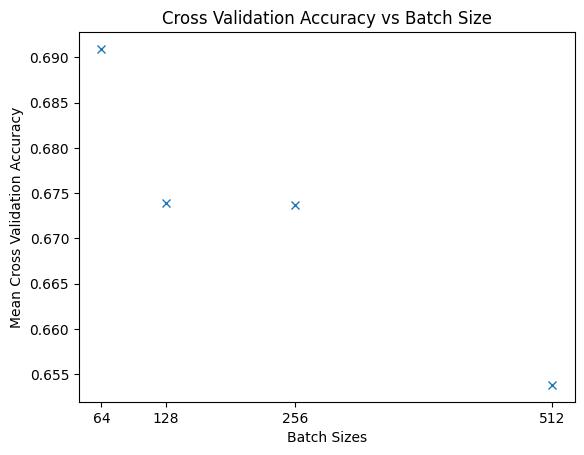

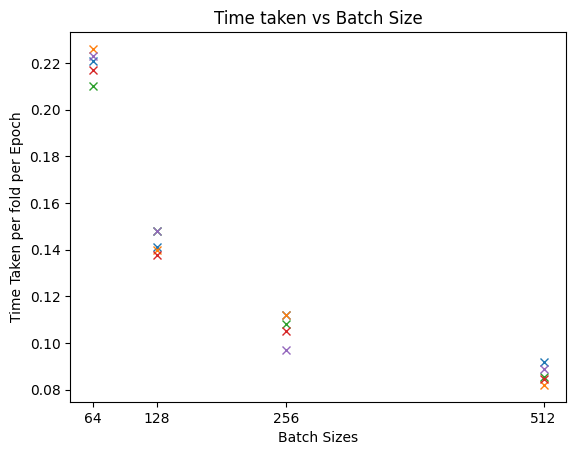

In [147]:
def scatterplot_accuracy(total_accuracy, batch_sizes):
    """Accuracy"""
    fig = plt.figure()
    plt.plot(batch_sizes, total_accuracy, marker='x', linestyle='None')
    plt.xticks(batch_sizes)
    plt.xlabel('Batch Sizes')
    plt.ylabel('Mean Cross Validation Accuracy')
    plt.title("Cross Validation Accuracy vs Batch Size")
    plt.show()

def scatterplot_time(total_time, batch_sizes):
    """Time"""
    fig = plt.figure()
    plt.plot(batch_sizes, total_time, marker='x', linestyle='None')
    plt.xticks(batch_sizes)
    plt.xlabel('Batch Sizes')
    plt.ylabel('Time Taken per fold per Epoch')
    plt.title("Time taken vs Batch Size")
    plt.show()

scatterplot_accuracy(cross_validation_accuracies, batch_sizes)
scatterplot_time(cross_validation_times, batch_sizes)

4.Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [148]:
df = pd.DataFrame({'Batch Size': batch_sizes,
                   'Mean Cross-Validation Accuracy': cross_validation_accuracies,
                  })

for time in range(len(cross_validation_times)):
    for fold in range(5):
        df.loc[time, f'Epoch Time for Fold {fold + 1}'] = cross_validation_times[time][fold]
df

,Batch Size,Mean Cross-Validation Accuracy,Epoch Time for Fold 1,Epoch Time for Fold 2,Epoch Time for Fold 3,Epoch Time for Fold 4,Epoch Time for Fold 5
0,64,0.690928,0.220998,0.226000,0.209999,0.217000,0.223001
1,128,0.673924,0.141001,0.140003,0.148000,0.137515,0.147998
2,256,0.673717,0.112000,0.111996,0.108000,0.104996,0.097001
3,512,0.653810,0.091995,0.081999,0.085510,0.084554,0.089000


In [150]:
# YOUR CODE HERE
optimal_batch_size = "256"
reason ="""
From the result, 

The general trend of the result is: 
    As batch size increases, the Mean Cross-Validation Accuracy decreases. 
    As batch size increases, the Epoch Time for a fold decreases. 

This shows that there is a trade off between high Mean Cross-Validation Accuracy and Epoch Time for a fold
for a given batch size

Given that we would want to ensure that our model has high accurancy value while not using too much 
computational resources. I would choose the optimal_batch_size to be 256 given that its Mean 
Cross-Validation Accruracy is relatively similar to that of batch size = 64 while having half the time 
for each epoch.

This is to strikes a good balance between maintaining high accuracy and reducing training time. 
"""